# Import libraries & settings

In [1]:
import os

import pandas as pd

from bs4 import BeautifulSoup

import shutil

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

import statsmodels.api as sm

In [2]:
# Settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 200)

In [3]:
# Path to root folder
dir_path = 'C:/Users/Adam/Documents/Out of the Park Developments/OOTP Baseball 24/saved_games/'

# Destination folder for processed game logs
destination_folder_pitchers = 'C:/Users/Adam/Desktop/OOTP/Pitchers_historical_logs'
destination_folder_batters = 'C:/Users/Adam/Desktop/OOTP/Batters_historical_logs'

# Destination folder for final data sets
destination_folder = 'C:/Users/Adam/Desktop/OOTP'

# Import and process logs

In [4]:
# Import HTML files
html_files = []

for root, dirs, files in os.walk(dir_path):
    if 'html' in dirs:
        temp_dir = os.path.join(root, 'html')
        if 'temp' in os.listdir(temp_dir):
            html_dir = os.path.join(temp_dir, 'temp')
            for file in os.listdir(html_dir):
                if file.endswith('.html'):
                    html_files.append(os.path.join(html_dir, file))


In [5]:
# Load the parquet "DBs" into a Pandas DataFrame
# https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d
# feather was impossible to set up
df_pitchers = pd.read_parquet(r'C:\Users\Adam\Desktop\OOTP\pitchers_db.parquet')
df_batters = pd.read_parquet(r'C:\Users\Adam\Desktop\OOTP\batters_db.parquet')

In [6]:
# ETL for new logs

for file in tqdm(html_files):
    # Reading the HTML file into a pandas DataFrame
    df = pd.read_html(file, flavor = 'bs4', skiprows=[0])[0]
    
    # delete the first row
    df = df.drop(0)
    # set the header and drop the row
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])
    
    # Check for duplicate column names
    duplicate_cols = df.columns[df.columns.duplicated()]
    # print(duplicate_cols) 

    # Get a boolean mask indicating which column names are duplicates
    dupe_mask = df.columns.duplicated()

    # Add a suffix to duplicate column names
    df.columns = df.columns.where(~dupe_mask, df.columns + '_other')
    
    # Concatenate the DataFrames for pitchers and batters independently
    if df.columns[6] == "STU":
        df_pitchers = pd.concat([df_pitchers, df])
        # Move
        shutil.move(file, destination_folder_pitchers)
    else:
        # Drop first column for batters
        df = df.drop(df.columns[0], axis=1)
        # Concat
        df_batters = pd.concat([df_batters, df])
        # Move
        shutil.move(file, destination_folder_batters)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [13:17<00:00, 31.89s/it]


In [7]:
# Store unaggregated data between sessions in parquet file
df_pitchers.to_parquet(r'C:\Users\Adam\Desktop\OOTP\pitchers_db.parquet')
df_batters.to_parquet(r'C:\Users\Adam\Desktop\OOTP\batters_db.parquet')

# Prepare Dataframes

## Data Types

### Pitchers

In [8]:
pitchers_data_types = {
                "POS": str, "Name": str, "ORG": str, "B": str, "T": str, "OVR": int, "STU": int,
                "MOV": int, "CON": int, "PBABIP": int, "HRR": int, "STU vL": int, "MOV vL": int,
                "CON vL": int, "PBABIP vL": int, "HRR vL": int, "STU vR": int, "MOV vR": int,
                "CON vR": int, "PBABIP vR": int, "HRR vR": int, "FB": int, "CH": int, "CB": int,
                "SL": int, "SI": int, "SP": int, "CT": int, "FO": int, "CC": int, "SC": int,
                "KC": int, "KN": int, "PIT": int, "G/F": str, "VELO": str, "Slot": str, "PT": str,
                "STM": int, "HLD": int, "IF RNG": int, "IF ERR": int, "IF ARM": int, "P": int,
                "G": int, "GS": int, "W": int, "L": int, "WIN%": float, "SVO": int, "SV": int,
                "SV%": float, "BS": int, "BS%": float, "HLD_other": int, "SD": int, "MD": int,
                "IP": float, "BF": int, "AB": int, "HA": int, "1B": int, "2B": int, "3B": int,
                "HR": int, "TB": int, "R": int, "ER": int, "BB": int, "IBB": int, "K": int,
                "HP": int, "ERA": float, "AVG": float, "OBP": float, "SLG": float, "OPS": float,
                "BABIP": float, "WHIP": float, "RA/9": float, "HR/9": float, "H/9": float,
                "BB/9": float, "K/9": float, "K/BB": float, "K%": float, "BB%": float,
                "K%-BB%": float, "SH": int, "SF": int, "WP": int, "BK": int, "CI": int, "DP": int,
                "RA": int, "GF": int, "IR": int, "IRS": int, "IRS%": float, "LOB%": float,
                "pLi": float, "GF%": float, "QS": int, "QS%": float, "CG": int, "CG%": float,
                "SHO": int, "PPG": int, "RS": int, "RSG": float, "PI": int, "GB": int,
                "FB_other": int, "GO%": float, "SB": int, "CS": int, "ERA+": int, "FIP": float,
                "FIP-": float, "WPA": float, "WAR": float, "rWAR": float, "SIERA": float,
                "TC": int, "A": int, "PO": int, "E": int, "DP_other": int, "TP": int, "PCT": float,
                "RNG": float, "ZR": float, "EFF": float}

In [9]:
for col, dtype in pitchers_data_types.items():
    if df_pitchers[col].dtype != dtype and dtype != 'str':
        df_pitchers[col] = df_pitchers[col].replace('-', 0)
        #df_pitchers[col] = pd.to_numeric(df_pitchers[col], errors='coerce').astype(dtype)
        df_pitchers[col] = df_pitchers[col].astype(dtype, errors = 'ignore')
        

In [10]:
df_pitchers = df_pitchers.convert_dtypes().reset_index(drop=True)
df_pitchers['VELO'] = df_pitchers['VELO'].str.split('-').str[0]

In [11]:
# decimal format of innings pitched 
df_pitchers['IP'] = df_pitchers['IP'].apply(lambda x: int(x) + (x % 1 * 10) / 3)

### Batters

In [12]:
batters_data_types = {'POS': str, 'Name': str, 'ORG': str, 'Lev': str, 'HT': str, 'B': str, 'T': str, 'OVR': int, 
                'BABIP': int, 'CON': int, 'GAP': int, 'POW': int, 'EYE': int, 'K\'s': int, 'BABIP vL': int, 
                'CON vL': int, 'GAP vL': int, 'POW vL': int, 'EYE vL': int, 'K vL': int, 'BABIP vR': int, 
                'CON vR': int, 'GAP vR': int, 'POW vR': int, 'EYE vR': int, 'K vR': int, 'BUN': int, 'BFH': int, 
                'BBT': str, 'GBT': str, 'FBT': str, 'C ABI': int, 'C ARM': int, 'IF RNG': int, 'IF ERR': int, 
                'IF ARM': int, 'TDP': int, 'OF RNG': int, 'OF ERR': int, 'OF ARM': int, 'DEF': int, 'P': int, 
                'C': int, '1B': int, '2B': int, '3B': int, 'SS': int, 'LF': int, 'CF': int, 'RF': int, 'SPE': int, 
                'STE': int, 'RUN': int, 'G': int, 'GS': int, 'PA': int, 'AB': int, 'H': int, '1B_other': int, 
                '2B_other': int, '3B_other': int, 'HR': int, 'RBI': int, 'R': int, 'BB': int, 'BB%': float, 'IBB': int, 
                'HP': int, 'SH': int, 'SF': int, 'CI': int, 'SO': int, 'SO%': float, 'GIDP': int, 'EBH': int, 'TB': int, 
                'AVG': float, 'OBP': float, 'SLG': float, 'RC': float, 'RC/27': float, 'ISO': float, 'wOBA': float, 'OPS': float,  
                'OPS+': int, 'BABIP_other': float, 'WPA': float, 'wRC': int, 'wRC+': int, 'wRAA': float, 'WAR': float, 
                'PI/PA': float, 'SB': int, 'CS': int, 'SB%': float, 'BatR': float, 'wSB': float, 'UBR': float, 'BsR': float, 
                'G_other': int, 'GS_other': int, 'TC': int, 'A': int, 'PO': int, 'E': int, 'DP': int, 'TP': int, 
                'PCT': float, 'RNG': float, 'ZR': float, 'EFF': float, 'SBA': int, 'RTO': int, 'RTO%': float, 'IP': float, 
                'PB': int, 'CER': int, 'CERA': float, 'BIZ-R%': float, 'BIZ-R': int, 'BIZ-Rm': int, 'BIZ-L%': float, 
                'BIZ-L': int, 'BIZ-Lm': int, 'BIZ-E%': float, 'BIZ-E': int, 'BIZ-Em': int, 'BIZ-U%': float, 
                'BIZ-U': int, 'BIZ-Um': int, 'BIZ-Z%': float, 'BIZ-Z': int, 'BIZ-Zm': int, 'BIZ-I': int, 'FRM': float, 
                'ARM': float, 'BF%': float}


In [13]:
df_batters['GS'].fillna('0', inplace=True)
df_batters['G'].replace({None: '0'}, inplace=True)

In [14]:
for col, dtype in batters_data_types.items():
    if df_batters[col].dtype != dtype and dtype != 'str':
        df_batters[col] = df_batters[col].replace('-', 0)
        #df_batters[col] = pd.to_numeric(df_batters[col], errors='coerce').astype(dtype)
        if col in ['BIZ-R%', 'BIZ-L%', 'BIZ-E%', 'BIZ-U%', 'BIZ-Z%', 'BF%']:
            df_batters[col] = df_batters[col].str.replace('%', '')
        df_batters[col] = df_batters[col].astype(dtype, errors = 'ignore')

In [15]:
df_batters = df_batters.convert_dtypes().reset_index(drop=True)

## Aggregations

### Pitcher aggregations

In [16]:
# # too slow
# wm = lambda x: np.average(x, weights=df_pitchers.loc[x.index, 'IP']) if df_pitchers.loc[x.index, 'IP'].sum() > 0 else np.nan
# ip9 = lambda x: np.average(x * (9/df_pitchers.loc[x.index, 'IP']), weights=df_pitchers.loc[x.index, 'IP']) if df_pitchers.loc[x.index, 'IP'].sum() > 0 else np.nan
# lambda_fncs = {col: ['sum', 'mean', wm, ip9] for col in df_pitchers.columns[53:]}

# %%time
# pitch_agg = df_pitchers_copy.agg(lambda_fncs)

In [17]:
wm_col = ["WIN%", "SV%", "BS%", "AVG", "OBP", "SLG", "OPS", "BABIP", "WHIP", "K/BB", "K%", "BB%", "K%-BB%", "IRS%", "LOB%", "pLi", "GF%", "QS%", "CG%", "PPG", "RS", "RSG", "PI", "GB", "FB_other", "GO%", "SB", "CS", "FIP", "FIP-", "SIERA", "PCT", "RNG", "ZR", "EFF"]

ip9_list = []

for item in df_pitchers[df_pitchers.iloc[:, 44:].columns]:
    if item not in wm_col:
            if item != 'IP':
                ip9_list.append(item)

In [18]:

# Aggregation per player and team
df_pitchers_agg_team = df_pitchers.copy()


df_pitchers_agg_team[wm_col] = df_pitchers_agg_team[wm_col].mul(df_pitchers_agg_team['IP'], axis=0)

# Group by the ratings' columns and sum the values
df_pitchers_agg_team = df_pitchers_agg_team.groupby(df_pitchers_agg_team.iloc[:, :44].columns.tolist()).sum()

# Reset index
df_pitchers_agg_team = df_pitchers_agg_team.reset_index()

# Save IP stats
df_pitchers_agg_team_IP = df_pitchers_agg_team['IP']

# Calculate statistics per 9 innings and update the corresponding columns
df_pitchers_agg_team[df_pitchers_agg_team.iloc[:, 44:].columns] = df_pitchers_agg_team[df_pitchers_agg_team.columns[44:]].div(df_pitchers_agg_team['IP'], axis=0)
df_pitchers_agg_team[ip9_list] = df_pitchers_agg_team[ip9_list].mul(9, axis=0)


# Drop columns that were already per 9 innings
df_pitchers_agg_team = df_pitchers_agg_team.drop(columns=['RA/9','HR/9','H/9','BB/9','K/9','ERA+'])

# Restore IP stats
df_pitchers_agg_team['IP'] = df_pitchers_agg_team_IP

In [19]:
# Aggregation per player
df_pitchers_agg = df_pitchers.copy()

df_pitchers_agg = df_pitchers_agg.drop(columns='ORG')

df_pitchers_agg[wm_col] = df_pitchers_agg[wm_col].mul(df_pitchers_agg['IP'], axis=0)

# Group by the ratings' columns and sum the values
df_pitchers_agg = df_pitchers_agg.groupby(df_pitchers_agg.iloc[:, :43].columns.tolist()).sum()

# Reset index
df_pitchers_agg = df_pitchers_agg.reset_index()

# Save IP stats
df_pitchers_agg_IP = df_pitchers_agg['IP']

# Calculate statistics per 9 innings and update the corresponding columns
df_pitchers_agg[df_pitchers_agg.iloc[:, 43:].columns] = df_pitchers_agg[df_pitchers_agg.columns[43:]].div(df_pitchers_agg['IP'], axis=0)
df_pitchers_agg[ip9_list] = df_pitchers_agg[ip9_list].mul(9, axis=0)


# Drop columns that were already per 9 innings
df_pitchers_agg = df_pitchers_agg.drop(columns=['RA/9','HR/9','H/9','BB/9','K/9','ERA+'])

# Restore IP stats
df_pitchers_agg['IP'] = df_pitchers_agg_IP

### Batter aggregations

In [20]:
pa600_list = ['G', 'GS','AB', 'H', '1B_other', '2B_other', '3B_other', 'HR', 'RBI', 'R', 'BB', 'IBB', 'HP', 'SH', 'SF', 'CI', 'SO', 'GIDP', 'EBH', 'TB', 'WPA', 'wRC', 'wRAA', 'WAR', 'SB', 'CS', 'BatR', 'wSB', 'UBR', 'BsR', 'G_other', 'GS_other', 'TC', 'A', 'PO', 'E', 'DP', 'TP', 'SBA', 'RTO']
wm_def_col = ['PB', 'CER', 'BIZ-R', 'BIZ-Rm', 'BIZ-L', 'BIZ-Lm', 'BIZ-E', 'BIZ-Em', 'BIZ-U', 'BIZ-Um', 'BIZ-Z', 'BIZ-Zm', 'BIZ-I', 'FRM', 'ARM']

wm_col = []

for item in df_batters[df_batters.iloc[:, 53:].columns]:
    if item not in pa600_list:
        if item not in wm_def_col:
#             if (item != 'PA') & ( item != 'IP'):
                wm_col.append(item)


In [21]:
# Aggregation per player and team
df_batters_agg_team = df_batters.copy()

df_batters_agg_team['PA_WM'] = df_batters_agg_team['PA']
df_batters_agg_team['IP_WM'] = df_batters_agg_team['IP']
df_batters_agg_team[wm_col] = df_batters_agg_team[wm_col].mul(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].mul(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].mul(df_batters_agg_team['IP_WM'], axis=0)

# Group by the ratings' columns and sum the values
df_batters_agg_team = df_batters_agg_team.groupby(df_batters_agg_team.iloc[:, :53].columns.tolist()).sum()

# Reset index
df_batters_agg_team = df_batters_agg_team.reset_index()

# Calculate statistics per 600 PAs and update the corresponding columns
df_batters_agg_team[wm_col] = df_batters_agg_team[wm_col].div(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].div(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].div(df_batters_agg_team['IP_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].div(df_batters_agg_team['PA'], axis=0).mul(600, axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].div(df_batters_agg_team['IP'], axis=0).mul(1000, axis=0)

In [22]:
# Aggregation per player
df_batters_agg = df_batters.copy()

df_batters_agg = df_batters_agg.drop(columns='ORG')

df_batters_agg['PA_WM'] = df_batters_agg['PA']
df_batters_agg['IP_WM'] = df_batters_agg['IP']
df_batters_agg[wm_col] = df_batters_agg[wm_col].mul(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].mul(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].mul(df_batters_agg['IP_WM'], axis=0)

# Group by the ratings' columns and sum the values
df_batters_agg = df_batters_agg.groupby(df_batters_agg.iloc[:, :52].columns.tolist()).sum()

# Reset index
df_batters_agg = df_batters_agg.reset_index()

# Calculate statistics per 600 PAs and update the corresponding columns
df_batters_agg[wm_col] = df_batters_agg[wm_col].div(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].div(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].div(df_batters_agg['IP_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].div(df_batters_agg['PA'], axis=0).mul(600, axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].div(df_batters_agg['IP'], axis=0).mul(1000, axis=0)


### Team aggregations

In [23]:
# Aggregate pitchers' data by team
df_team_agg = df_pitchers.groupby('ORG')[['W','L','HR','R', 'ER', 'BB', 'K']].sum().copy()

# Rename columns
df_team_agg = df_team_agg.rename(columns={'HR': 'HRA', 'R': 'RA', 'ER': 'ERA', 'BB': 'BBA'})

# Calculate winning rate
df_team_agg['WRATE'] = df_team_agg['W']/(df_team_agg['W']+df_team_agg['L'])

# Merge with batters' data by team
df_team_agg = df_team_agg.merge( df_batters.groupby('ORG')[['H','HR', 'R', 'BB']].sum().reset_index(), on='ORG', how='left')

# Filter teams with more than 10 wins, and sort by winning rate
df_team_agg[df_team_agg['W'] > 10].sort_values('WRATE', ascending=False)

,ORG,W,L,HRA,RA,ERA,BBA,K,WRATE,H,HR,R,BB
46,Big Bang Expansion - TTC,13,2,16,49,47,59,82,0.866667,155,12,82,91
182,JoT Doo,16,3,17,61,60,84,151,0.842105,171,33,112,103
151,Goyang Cats,12,3,18,63,58,59,123,0.8,134,19,86,73
153,Grand Prairie Air Hogs,12,4,17,69,64,63,118,0.75,145,26,90,83
362,St-Amandsberg Neptuun,11,4,22,55,53,60,101,0.733333,127,20,79,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,F2P TBD,12,14,35,116,106,98,188,0.461538,215,22,108,121
418,West Oz Wallabies,11,14,27,132,126,108,167,0.44,214,38,128,136
231,Middletown Dreamers,29,39,61,344,330,444,535,0.426471,601,54,319,328
342,Shreveport Generals,11,15,27,164,156,205,211,0.423077,246,20,139,152


# Analysis

## My team comparison

### Batting

In [24]:
df_batters_agg_team[df_batters_agg_team['ORG'] == 'Fogtown Stars'].sort_values('WAR', ascending=False)

,POS,Name,ORG,Lev,HT,B,T,OVR,BABIP,CON,GAP,POW,EYE,K's,BABIP vL,CON vL,GAP vL,POW vL,EYE vL,K vL,BABIP vR,CON vR,GAP vR,POW vR,EYE vR,K vR,BUN,BFH,BBT,GBT,FBT,C ABI,C ARM,IF RNG,IF ERR,IF ARM,TDP,OF RNG,OF ERR,OF ARM,DEF,P,C,1B,2B,3B,SS,LF,CF,RF,SPE,STE,RUN,G,GS,PA,AB,H,1B_other,2B_other,3B_other,HR,RBI,R,BB,BB%,IBB,HP,SH,SF,CI,SO,SO%,GIDP,EBH,TB,AVG,OBP,SLG,RC,RC/27,ISO,wOBA,OPS,OPS+,BABIP_other,WPA,wRC,wRC+,wRAA,WAR,PI/PA,SB,CS,SB%,BatR,wSB,UBR,BsR,G_other,GS_other,TC,A,PO,E,DP,TP,PCT,RNG,ZR,EFF,SBA,RTO,RTO%,IP,PB,CER,CERA,BIZ-R%,BIZ-R,BIZ-Rm,BIZ-L%,BIZ-L,BIZ-Lm,BIZ-E%,BIZ-E,BIZ-Em,BIZ-U%,BIZ-U,BIZ-Um,BIZ-Z%,BIZ-Z,BIZ-Zm,BIZ-I,FRM,ARM,BF%,PA_WM,IP_WM
3131,CF,Gorman Thomas,Fogtown Stars,TRN,"6' 2""",Right,Right,61,47,59,62,109,90,31,48,64,66,117,91,33,47,58,60,107,90,30,27,7,Flyball,Ex. Pull,Normal,0,0,10,3,10,8,71,63,51,52,0,0,0,0,0,0,0,52,0,34,55,68,241.98895,116.022099,11.3125,493.922652,159.116022,72.928177,21.546961,0.0,64.640884,145.856354,135.911602,106.077348,15.625,0.0,0.0,0.0,0.0,0.0,134.254144,21.871875,21.546961,86.187845,374.585635,0.3315,0.437281,0.80175,3.14375,14.121875,0.470219,0.513406,1.239187,245.0625,0.314844,9.58011,119.337017,249.40625,87.016575,11.933702,4.467812,0.0,0.0,0.0,87.016575,0.0,10.607735,10.607735,62.983425,0.0,39.779006,0.0,39.779006,0.0,0.0,0.0,0.375,1.6875,-0.1875,0.252375,0.0,0.0,0.0,2.15625,0.0,0.0,0.0,37.5,265.010352,265.010352,37.5,265.010352,265.010352,0.0,265.010352,0.0,0.0,0.0,0.0,0.0,265.010352,0.0,0.0,0.0,53.00207,100.0,32,7.0
1927,3B,Mike Moustakas,Fogtown Stars,TRN,"6' 0""",Left,Right,69,45,64,65,78,64,76,44,61,64,71,58,78,45,65,66,80,66,76,17,5,Flyball,Normal,Pull,0,0,63,64,84,55,1,5,5,71,0,0,0,64,71,0,0,0,0,18,75,46,140.071578,136.295199,21.801794,525.064791,149.672961,91.472294,34.456374,1.431569,22.312724,80.093792,85.0796,67.555226,10.93713,1.949895,2.566951,0.0,4.813032,0.0,77.94644,13.721794,18.659756,58.200666,253.930643,0.271233,0.351589,0.461362,3.575336,7.022063,0.19016,0.362112,0.812891,113.991031,0.280504,2.040232,78.686906,115.258296,18.00074,4.980871,3.676269,0.0,0.0,0.0,18.00074,0.0,-1.764778,-1.764778,139.133654,136.295199,301.419227,263.680118,32.383068,5.356041,22.189313,0.0,0.982382,2.203892,0.374081,1.019623,0.0,0.0,0.0,44.854978,0.0,0.0,0.0,94.752646,130.349673,124.427314,76.720717,41.30436,37.566052,49.178027,28.658439,20.005054,39.730942,15.243092,10.64869,28.983408,22.838156,10.015046,21.862652,0.0,0.0,99.052018,1115,2315.1
858,2B,Dink Mothell,Fogtown Stars,TRN,"6' 0""",Switch,Right,69,75,71,89,43,101,55,76,71,90,44,102,55,75,71,89,43,101,55,96,100,Line Drive,Spray,Pull,61,60,67,68,62,71,74,61,66,73,120,57,80,73,61,0,89,59,77,69,80,74,140.887489,113.16347,20.331781,516.484397,162.290295,109.728027,37.961638,2.95448,11.646149,73.655883,97.051245,75.785857,13.621187,0.687088,1.511595,1.064987,5.153163,0.0,103.990839,16.304889,8.554251,52.562267,241.099342,0.318488,0.40566,0.467119,3.759255,9.150175,0.148625,0.391183,0.872773,131.128056,0.371608,5.156942,85.851703,133.059371,23.240767,3.703407,4.458172,15.012883,8.62296,33.899884,23.240767,0.285142,-1.370741,-1.089035,147.380475,113.16347,454.852562,260.853135,190.59834,3.401088,75.236187,0.0,0.985757,3.740291,-0.163795,0.98124,0.721443,0.721443,2.444703,37.311292,0.0,10.318301,0.082806,88.779977,159.01012,144.089535,48.31525,41.026468,24.870497,23.108033,37.291182,14.740674,12.764377,33.653561,5.455574,11.812689,32.695751,7.460292,43.687432,-0.181967,0.015421,99.222352,859,1564.2
3665,LF,Brad Wilkerson,Fogtown Stars,TRN,"6' 0""",Left,Left,67,83,69,69,62,89,36,83,68,70,60,84,35,83,69,69,62,91,36,24,2,Groundball,Ex. Pull,Normal,0,0,34,33,34,36,71,51,95,90,0,0,52,0,0,0,90,56,0,57,56,45,130.99866,130.99866,24.260163,511.105898,135.301609,84.309651,26.260054,6.112601,18.619303,78.317694,86.541555,80.670241,13.331707,2.312332,4.162198,0.0,4.061662,0.0,134.396783,23.004472,10.274799,50.991957,229.644772,0.261321,0.364179,0.441089,3.805772,7.125528,0.179768,0.362141,0.805307,113.045528,0.325676,2.998391,74.19571,

### Catching

In [25]:
df_batters_agg_team[(df_batters_agg_team['ORG'] == 'Fogtown Stars') & (df_batters_agg_team['POS'] == 'C')][['Name','C ABI','C ARM','CERA']].sort_values('CERA', ascending=True)

,Name,C ABI,C ARM,CERA
2718,Ozzie Virgil,66,53,3.942034
2484,Ernie Whitt,67,57,4.219891


### Pitching

#### Starters

In [26]:
df_pitchers_agg_team[(df_pitchers_agg_team['ORG'] == 'Fogtown Stars') & (df_pitchers_agg_team['POS'] == 'SP')].sort_values('ERA', ascending=False)

,POS,Name,ORG,B,T,OVR,STU,MOV,CON,PBABIP,HRR,STU vL,MOV vL,CON vL,PBABIP vL,HRR vL,STU vR,MOV vR,CON vR,PBABIP vR,HRR vR,FB,CH,CB,SL,SI,SP,CT,FO,CC,SC,KC,KN,PIT,G/F,VELO,Slot,PT,STM,HLD,IF RNG,IF ERR,IF ARM,P,G,GS,W,L,WIN%,SVO,SV,SV%,BS,BS%,HLD_other,SD,MD,IP,BF,AB,HA,1B,2B,3B,HR,TB,R,ER,BB,IBB,K,HP,ERA,AVG,OBP,SLG,OPS,BABIP,WHIP,K/BB,K%,BB%,K%-BB%,SH,SF,WP,BK,CI,DP,RA,GF,IR,IRS,IRS%,LOB%,pLi,GF%,QS,QS%,CG,CG%,SHO,PPG,RS,RSG,PI,GB,FB_other,GO%,SB,CS,FIP,FIP-,WPA,WAR,rWAR,SIERA,TC,A,PO,E,DP_other,TP,PCT,RNG,ZR,EFF
3895,SP,Jordan Montgomery,Fogtown Stars,Left,Left,69,55,68,75,63,67,57,70,76,65,69,55,67,75,63,67,53,45,49,0,64,0,49,0,0,0,0,0,5,NEU,93,Normal (3/4),Normal,62,64,17,13,34,36,3.375,3.375,0.0,3.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.666667,60.75,50.625,23.625,20.25,3.375,0.0,0.0,27.0,20.25,20.25,10.125,0.0,10.125,0.0,68.34375,0.467,0.556,0.533,1.089,0.583,3.75,1.0,16.7,16.7,0.0,0.0,0.0,6.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1.28,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,0.0,56.0,4.0,1.0,0.8,1.0,0.0,3.85,92.0,-1.35,0.0,-1.0125,5.44,3.375,3.375,0.0,0.0,0.0,0.0,1.0,3.38,-0.2,1.004
3745,SP,Johnny Antonelli,Fogtown Stars,Left,Left,69,86,68,51,67,67,85,68,51,66,66,86,69,51,67,67,80,0,87,49,0,0,0,0,0,69,0,0,4,NEU,92,Normal (3/4),Normal,74,77,29,24,26,62,1.875,1.875,0.75,0.375,0.708333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.000000,34.5,31.125,5.25,2.625,0.375,0.375,1.875,12.0,5.25,5.25,2.625,0.0,14.625,0.375,53.26875,0.157444,0.206347,0.362667,0.569583,0.191014,0.874722,11.684722,43.759722,5.258333,38.445833,0.0,0.375,0.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,77.019444,0.798056,0.0,1.125,0.770833,0.0,0.0,0.0,89.083333,6.513889,3.277778,178.833333,7.583333,8.138889,0.476389,0.430556,0.0,2.89125,74.583333,-0.1125,0.225,0.0375,0.789028,0.75,0.375,0.375,0.0,0.0,0.0,0.555556,0.75,-0.215278,0.557222
4304,SP,Martin Perez,Fogtown Stars,Left,Left,69,54,89,59,50,92,58,95,60,53,96,53,87,58,49,90,49,0,33,37,68,0,58,0,38,0,0,0,6,GB,93,3/4,GB'er,78,76,20,18,54,50,1.928571,1.928571,0.385714,1.028571,0.271429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.000000,43.328571,37.928571,12.985714,7.842857,4.371429,0.257143,0.514286,19.414286,7.2,6.814286,4.5,0.0,5.4,0.257143,35.208,0.324324,0.3916,0.488314,0.879986,0.365043,1.942048,1.258095,12.26619,9.875714,2.4,0.128571,0.514286,0.385714,0.0,0.0,0.9,0.0,0.0,0.0,0.0,0.0,67.493333,1.028095,0.0,0.257143,0.214286,0.128571,0.128571,0.0,99.485714,2.780952,2.780952,99.485714,8.095238,4.695238,0.611952,0.428571,0.504762,4.038762,89.819048,-0.347143,0.154286,-0.038571,5.434381,1.414286,0.9,0.385714,0.128571,0.0,0.0,0.452381,1.285714,-0.001905,0.383467
2868,SP,Alex Wood,Fogtown Stars,Right,Left,68,75,59,74,50,61,87,69,78,59,72,71,55,73,48,57,0,0,0,78,74,0,0,0,64,0,0,0,3,NEU,92,3/4,Normal,70,76,40,41,44,86,1.679818,1.679818,0.491654,0.491654,0.350531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,219.666667,38.676783,34.088012,8.522003,5.654021,1.556904,0.081942,1.229135,13.930197,4.793627,4.711684,3.810319,0.0,9.218513,0.368741,9.789241,0.240015,0.320217,0.388326,0.708598,0.294935,1.370212,2.557663,24.063278,9.551897,14.505463,0.163885,0.245827,0.204856,0.081942,0.0,0.655539,0.0,0.0,0.0,0.0,0.0,75.189985,0.973111,0.0,0.69651,0.508346,0.0,0.0,0.0,97.603945,3.883156,3.488619,105.379363,5.418816,6.233687,0.457815,0.396055,0.2261,4.114036,90.805766,-0.073748,0.192564,0.172079,3.548103,1.270106,0.901366,0.286798,0.081942,0.0,0.0,0.491654,1.188816,-0.018361,0.379918
3951,SP,Jumbo Elliott,Fogtown Stars,Right,Left,69,76,74,61,64,73,74,73,61,63,71,76,75,61,65,74,73,71,84,0,0,0,0,0,0,0,0,0,3,FB,90,3/4,Normal,76,55,20,19,19,43,1.710214,1.710214,0.598575,0.534442,0.514648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,421.000000,39.249406,34.375297,9.021378,5.494062,1.92399,0.213777,1.389549,15.541568,5.258907,4.852732,4.147268,0.0,8.08076,0.149644,7.721188,0.25587,0.333072,0.439641,0.772847,0.293577,1.463207,2.612668,20.752415,10.343626,10.39905,0.128266,0.448931,0.213777,0.042755,0.0,0.833729,0.0,0.0,0.0,0.0,0.0,73.143468,1.040752,0.0,0.748219,0.524149,0.021378,0.01425

#### Relievers

In [27]:
df_pitchers_agg_team[(df_pitchers_agg_team['ORG'] == 'Fogtown Stars') & (df_pitchers_agg_team['POS'].isin(['RP','CL']))].sort_values('ERA', ascending=True)

,POS,Name,ORG,B,T,OVR,STU,MOV,CON,PBABIP,HRR,STU vL,MOV vL,CON vL,PBABIP vL,HRR vL,STU vR,MOV vR,CON vR,PBABIP vR,HRR vR,FB,CH,CB,SL,SI,SP,CT,FO,CC,SC,KC,KN,PIT,G/F,VELO,Slot,PT,STM,HLD,IF RNG,IF ERR,IF ARM,P,G,GS,W,L,WIN%,SVO,SV,SV%,BS,BS%,HLD_other,SD,MD,IP,BF,AB,HA,1B,2B,3B,HR,TB,R,ER,BB,IBB,K,HP,ERA,AVG,OBP,SLG,OPS,BABIP,WHIP,K/BB,K%,BB%,K%-BB%,SH,SF,WP,BK,CI,DP,RA,GF,IR,IRS,IRS%,LOB%,pLi,GF%,QS,QS%,CG,CG%,SHO,PPG,RS,RSG,PI,GB,FB_other,GO%,SB,CS,FIP,FIP-,WPA,WAR,rWAR,SIERA,TC,A,PO,E,DP_other,TP,PCT,RNG,ZR,EFF
621,RP,Alex Cobb,Fogtown Stars,Right,Right,69,62,86,58,63,86,60,84,58,61,83,63,89,59,65,88,47,0,55,0,72,66,0,0,0,0,0,0,4,GB,91,Normal (3/4),GB'er,64,55,35,25,30,71,7.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.928571,0.0,0.0,4.666667,36.642857,30.857143,3.857143,1.928571,1.928571,0.0,0.0,5.785714,0.0,0.0,5.785714,0.0,9.642857,0.0,0.0,0.120929,0.2525,0.180214,0.432714,0.175,1.071429,0.964286,26.892857,13.928571,12.964286,0.0,0.0,0.0,0.0,0.0,0.0,7.714286,3.857143,0.0,0.0,0.0,100.0,0.467143,0.392857,0.0,0.0,0.0,0.0,0.0,17.214286,0.0,0.0,20.428571,1.785714,1.428571,0.560714,0.0,0.0,2.264286,54.571429,0.192857,0.385714,0.578571,3.9,1.928571,1.928571,0.0,0.0,0.0,0.0,0.357143,1.928571,0.035714,0.358214
780,RP,Bob Walk,Fogtown Stars,Right,Right,69,35,107,57,81,102,32,98,55,77,98,37,115,58,85,106,0,14,39,32,63,0,0,0,0,0,0,0,4,GB,90,Normal (3/4),GB'er,74,55,28,22,26,59,4.05,0.0,2.7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.7,0.0,6.666667,37.8,33.75,6.75,6.75,0.0,0.0,0.0,6.75,0.0,0.0,4.05,0.0,4.05,0.0,0.0,0.2,0.27905,0.2,0.47905,0.22785,1.1965,1.475,11.03,9.875,1.125,0.0,0.0,1.35,0.0,0.0,0.0,4.05,0.0,4.05,0.0,0.0,100.0,0.539,0.0,0.0,0.0,0.0,0.0,0.0,33.7,0.0,0.0,50.6,5.6,3.0,0.63,0.0,0.65,3.0535,73.35,0.27,0.135,0.54,5.6175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.195,0.0
1713,RP,Jon Garland,Fogtown Stars,Right,Right,69,47,76,83,77,72,47,76,83,76,71,47,77,83,78,73,0,35,47,30,61,38,39,0,0,0,0,0,6,NEU,90,Over the Top,Finesse,65,105,39,30,37,80,2.842105,0.0,0.0,0.0,0.0,2.842105,1.421053,0.473684,0.0,0.0,0.0,1.421053,0.0,6.333333,32.684211,27.0,1.421053,1.421053,0.0,0.0,0.0,1.421053,0.0,0.0,5.684211,0.0,8.526316,0.0,0.0,0.047895,0.216316,0.047895,0.264211,0.065789,0.791053,1.5,26.368421,17.578947,8.789474,0.0,0.0,0.0,0.0,0.0,1.421053,2.842105,1.421053,2.842105,0.0,0.0,100.0,0.526842,0.473684,0.0,0.0,0.0,0.0,0.0,48.736842,0.0,0.0,48.736842,3.526316,2.526316,0.584211,0.0,0.0,2.563684,61.684211,0.142105,0.284211,0.568421,4.267895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.105263,0.0
1851,RP,Kevin Slowey,Fogtown Stars,Right,Right,69,59,47,98,57,48,57,46,97,55,47,60,48,99,58,49,46,67,43,44,61,0,0,0,0,0,0,0,5,EX FB,90,Over the Top,Finesse,63,70,27,27,25,61,4.5,0.0,0.5,0.0,0.425926,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18.000000,32.5,31.5,5.0,2.5,1.0,0.0,1.5,10.5,2.5,2.5,1.0,0.0,6.5,0.0,3.9,0.157019,0.182333,0.329796,0.51213,0.146574,0.665741,2.037037,20.081481,3.025926,17.055556,0.0,0.0,0.5,0.0,0.0,0.0,4.5,1.5,1.5,0.0,0.0,78.703704,0.473704,0.316463,0.0,0.0,0.0,0.0,0.0,27.574074,0.0,0.0,83.611111,5.314815,8.611111,0.397963,0.0,0.259259,3.54463,89.648148,0.25,0.1,0.2,3.152037,0.5,0.0,0.5,0.0,0.0,0.0,0.314815,0.500556,0.077778,0.0
2078,RP,Melido Perez,Fogtown Stars,Right,Right,69,83,73,48,61,73,79,70,47,59,70,87,77,49,64,77,81,0,0,69,0,0,0,78,0,0,0,0,3,NEU,92,Over the Top,Normal,83,58,27,21,23,55,9.0,0.0,1.125,1.125,0.25,7.875,6.75,0.875,1.125,0.125,0.0,5.625,1.125,8.000000,33.75,29.25,4.5,3.375,0.0,0.0,1.125,7.875,2.25,2.25,4.5,0.0,12.375,0.0,5.0625,0.1395,0.2585,0.255,0.513,0.2,1.0,2.75,35.85,13.6,22.2,0.0,0.0,0.0,0.0,0.0,2.25,9.0,9.0,0.0,0.0,0.0,88.45,1.6075,1.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,54.75,1.5,2.25,0.395,0.0,0.0,2.86,70.25,0.0,0.1125,0.225,2.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2522,RP,Storm Davis,Fogtown Stars,Right,Right,68,63,79,60,71,77,63,79,60,71,76,63,79,60,72,77,71,61,0,0,0,0,0,71,0,0,0,0,3,NEU,91,Normal (3/4),Normal,72,66,26,25,23,57,4.973684,0.0,0.0,0.0,0.0,1.421053,0.710526,0.421053,0.0,0.0,0.0,0.0,0.710526,12.666667,40.5,34.815789,9.2368

## Player analytics

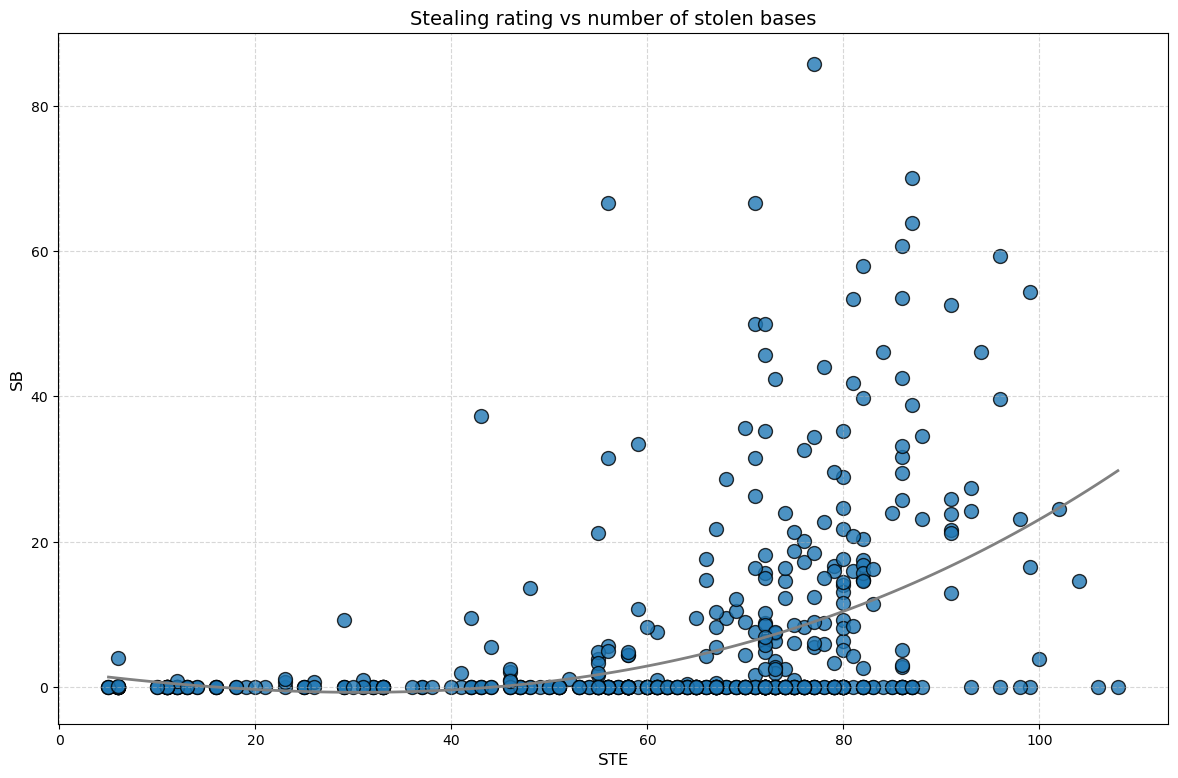

In [28]:
# Stolen bases

# Remove outliers using IQR method
Qd = df_batters_agg['SB'].astype(float).quantile(0.05)
Qu = df_batters_agg['SB'].astype(float).quantile(0.95)
IQR = Qu - Qd
lower_bound = Qd - 1.5 * IQR # not exclding anything but good to have it for completness
upper_bound = Qu + 1.5 * IQR

# Filter the data to remove outliers
series_sb = np.nan_to_num(df_batters_agg['SB'][(df_batters_agg['SB'] >= lower_bound) & (df_batters_agg['SB'] <= upper_bound)].astype(float), nan=0.0)
series_ste = np.nan_to_num(df_batters_agg['STE'][(df_batters_agg['SB'] >= lower_bound) & (df_batters_agg['SB'] <= upper_bound)].astype(float), nan=0.0)

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a scatter plot
plt.scatter(series_ste, series_sb, s=100,
            marker='o', edgecolors='black', alpha=0.8)

# Calculate polynomial fit
coefficients = np.polyfit(series_ste, series_sb, 3)
polynomial = np.poly1d(coefficients)
x_values = np.linspace(min(series_ste), max(series_ste), 100)
y_values = polynomial(x_values)


# Plot the trendline
plt.plot(x_values, y_values, color='grey', linewidth=2, label='Trendline')

# Set labels and title
plt.xlabel('STE', fontsize=12)
plt.ylabel('SB', fontsize=12)
plt.title('Stealing rating vs number of stolen bases', fontsize=14)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Customize tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Increase spacing between subplots
plt.tight_layout(pad=1.5)

# Show the plot
plt.show()


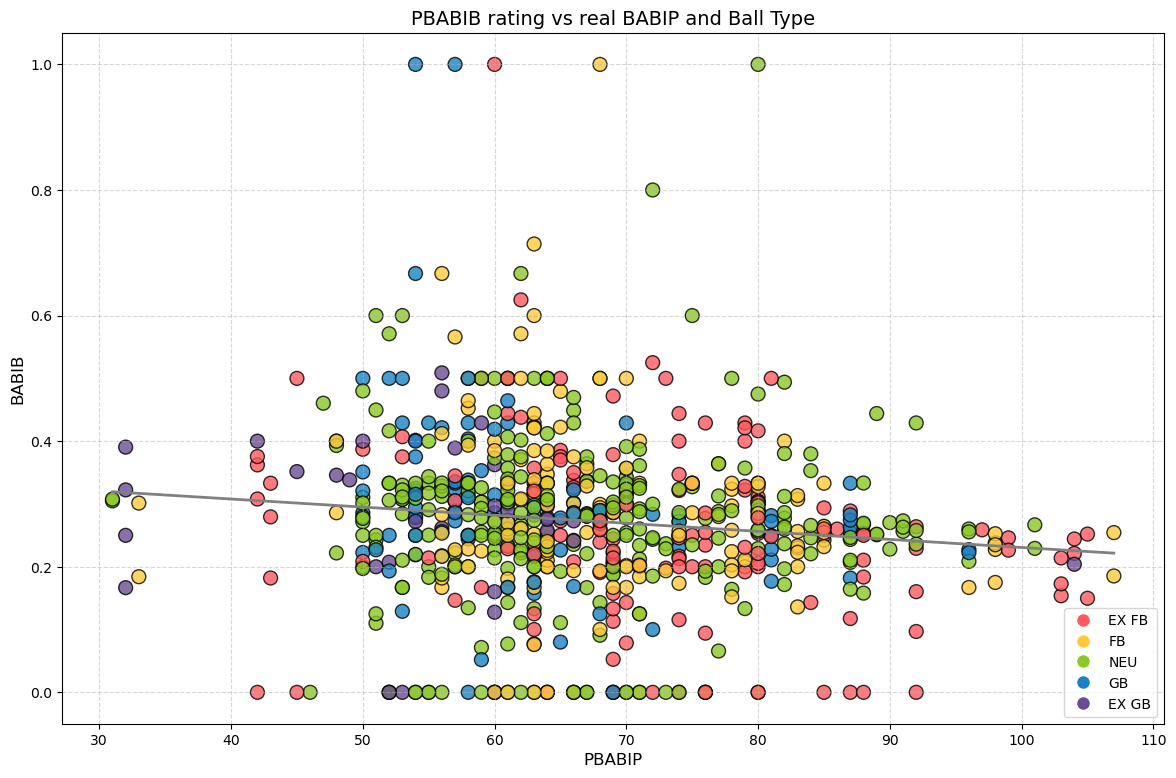

In [29]:
# Set custom color palette for different 'G/F' categories
colors = {'EX FB': '#FF595E', 'FB': '#FFCA3A', 'NEU': '#8AC926', 'GB': '#1982C4', 'EX GB': '#6A4C93'}

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a scatter plot
plt.scatter(df_pitchers_agg['PBABIP'], df_pitchers_agg['BABIP'], s=100, c=df_pitchers_agg['G/F'].map(colors),
            marker='o', edgecolors='black', alpha=0.8)

# # Calculate polynomial fit
# coefficients = np.polyfit(df_pitchers_agg['BABIP'].astype(float), df_pitchers_agg['PBABIP'].astype(float), 1)
# polynomial = np.poly1d(coefficients)
# x_values = np.linspace(min(df_pitchers_agg['BABIP']), max(df_pitchers_agg['BABIP']), 100)
# y_values = polynomial(x_values)

# from sklearn.linear_model import Ridge

# # Fit a ridge regression model
# ridge = Ridge(alpha=1.0)  # You can adjust the alpha parameter
# ridge.fit(np.vander(np.nan_to_num(df_pitchers_agg['BABIP'], nan=0.0), 3), np.nan_to_num(df_pitchers_agg['PBABIP'], nan=0.0))

# # Generate predicted values using the ridge model
# y_values = ridge.predict(np.vander(x_values, 3))

# Fit linear regression
X = sm.add_constant(np.nan_to_num(df_pitchers_agg['PBABIP'].astype(float), nan=0.0))
model = sm.OLS(np.nan_to_num(df_pitchers_agg['BABIP'].astype(float), nan=0.0), X)
results = model.fit()
intercept, slope = results.params

# Generate the linear regression line
x_values = np.linspace(min(np.nan_to_num(df_pitchers_agg['PBABIP'].astype(float), nan=0.0)), max(np.nan_to_num(df_pitchers_agg['PBABIP'].astype(float), nan=0.0)), 100)
y_values = intercept + slope * x_values

# Plot the trendline
plt.plot(x_values, y_values, color='grey', linewidth=2, label='Trendline')

# Set labels and title
plt.xlabel('PBABIP', fontsize=12)
plt.ylabel('BABIB', fontsize=12)
plt.title('PBABIB rating vs real BABIP and Ball Type', fontsize=14)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Customize tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['EX FB'], markersize=10, label='EX FB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['FB'], markersize=10, label='FB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['NEU'], markersize=10, label='NEU'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['GB'], markersize=10, label='GB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['EX GB'], markersize=10, label='EX GB')]
plt.legend(handles=legend_elements, loc='lower right')

# NOTE: ADD OPACITY BASED ON PITCHED INNINGS

# Increase spacing between subplots
plt.tight_layout(pad=1.5)

# Save the plot as an image (optional)
# plt.savefig('scatter_plot_with_trendline.png', dpi=300)

# Show the plot
plt.show()


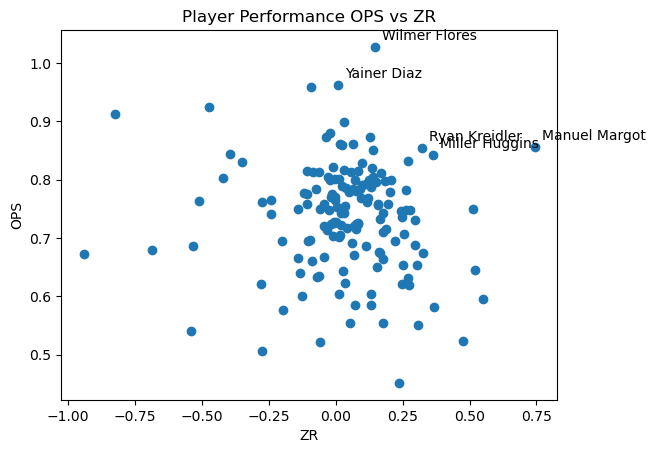

In [30]:
# Standardization
def standardize(column):
    mean = np.mean(column)
    std = np.std(column)
    standardized_column = (column - mean) / std
    return standardized_column
# Normalization
def min_max_normalize(column):
    min_val = min(column)
    max_val = max(column)
    normalized_column = [(val - min_val) / (max_val - min_val) for val in column]
    return normalized_column

data = df_batters_agg[df_batters_agg['PA_WM'] > 100]

# Separate data into x and y coordinates
x = data['ZR']
y = data['OPS']
names = data['Name']


# Create scatter plot
plt.scatter(x, y)

# Find the indices of the top 5 records in the right-top quadrant
top_records_indices = sorted(range(len(x)), key=lambda i: (standardize(x).iloc[i] + standardize(y).iloc[i]))[-5:]

# Add names to the top records
for index in top_records_indices:
    plt.annotate(names.iloc[index], (x.iloc[index], y.iloc[index]), xytext=(5, 5), textcoords='offset points')

# Set labels and title
plt.xlabel('ZR')
plt.ylabel('OPS')
plt.title('Player Performance OPS vs ZR')

# Display the chart
plt.show()


## Modeling

### Batting

In [31]:
# categorical predictors into numerical
df_batters_agg_model = pd.get_dummies(df_batters_agg, columns=['BBT','GBT','FBT'], drop_first=True)

# Dummy Variable Trap -> two or more dummy variables created by one-hot encoding are highly correlated (multi-collinear) -> drop_first=True

# outliers removal 
# 1) remove of players with not enough data collected based on the plate apperarances
df_batters_agg_model = df_batters_agg_model[df_batters_agg_model['PA_WM'] > 400]

In [32]:
predictors_batters = [
    'BABIP', 'CON', 'GAP', 'POW', 'EYE', "K's", 'BABIP vL', 'CON vL',
    'GAP vL', 'POW vL', 'EYE vL', 'K vL', 'BABIP vR', 'CON vR', 'GAP vR',
    'POW vR', 'EYE vR', 'K vR', 'BUN', 'BFH', 'BBT_Groundball',
    'BBT_Line Drive', 'BBT_Normal', 'GBT_Normal', 'GBT_Pull',
    'GBT_Spray', 'FBT_Pull', 'FBT_Spray'
]

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#### Correlation

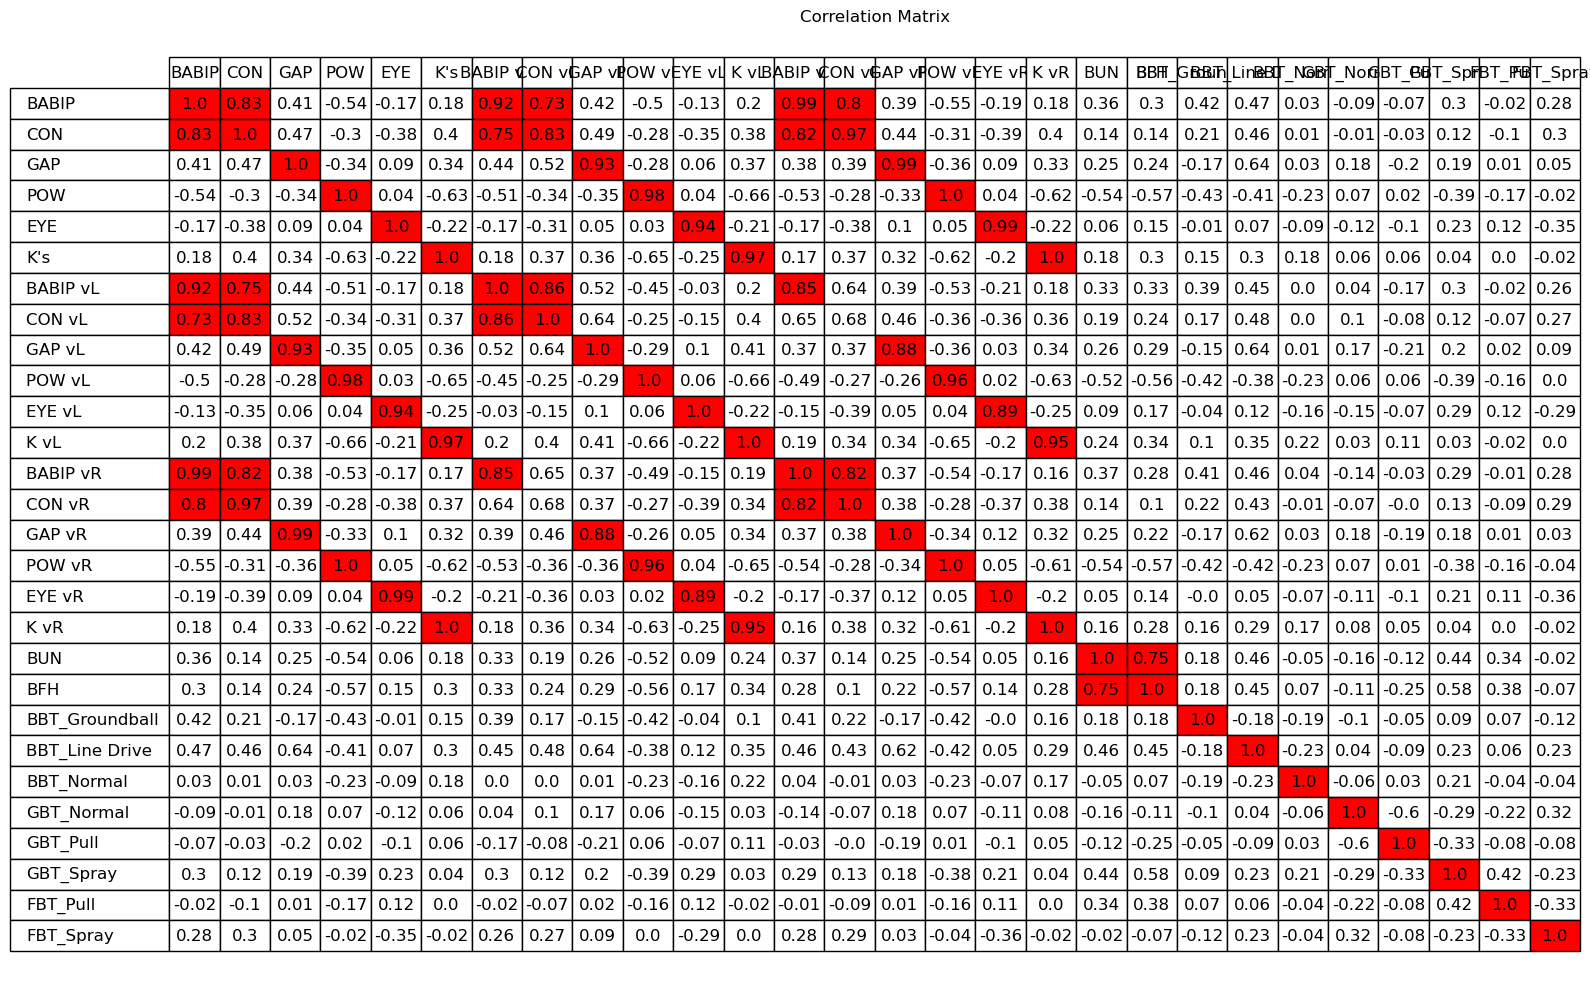

In [34]:
# Correlation matrix
correlation_matrix = df_batters_agg_model[predictors_batters].corr()

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(16, 10))

# Create a table plot
table = plt.table(cellText=correlation_matrix.round(2).values,
                  cellColours=np.where(np.abs(correlation_matrix.values) >= 0.7, 'red', 'white'),
                  rowLabels=correlation_matrix.index,
                  colLabels=correlation_matrix.columns,
                  cellLoc='center',
                  loc='center')

# Set table properties
table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(12)

# Hide axis
ax.axis('off')

# Set plot title
plt.title('Correlation Matrix')

# Adjust plot layout
plt.tight_layout()

# Show the plot
plt.show()

In [35]:
def get_correlated_pairs(correlation_matrix, threshold):
    pairs = []
    n = correlation_matrix.shape[0]

    for i in range(n):
        for j in range(i+1, n):
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) >= threshold:
                pair = (correlation_matrix.columns[i], correlation_matrix.columns[j], correlation)
                pairs.append(pair)

    return pairs

In [36]:
# Example usage
threshold = 0.8  # Correlation threshold
correlated_pairs = get_correlated_pairs(correlation_matrix, threshold)

# Print the correlated pairs
for pair in correlated_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]}")

BABIP - CON: 0.8291552973737604
BABIP - BABIP vL: 0.9151102769071738
BABIP - BABIP vR: 0.9891554482012599
CON - CON vL: 0.8298309573813595
CON - BABIP vR: 0.8212115672043686
CON - CON vR: 0.9722664444920247
GAP - GAP vL: 0.9329352072202611
GAP - GAP vR: 0.9911790726468412
POW - POW vL: 0.9788562770949611
POW - POW vR: 0.9980542235904296
EYE - EYE vL: 0.9388475249083772
EYE - EYE vR: 0.9935280025889344
K's - K vL: 0.9725428176225831
K's - K vR: 0.9973360809696328
BABIP vL - CON vL: 0.8644405270938293
BABIP vL - BABIP vR: 0.8466419386626582
GAP vL - GAP vR: 0.8779882160354938
POW vL - POW vR: 0.9646274356279742
EYE vL - EYE vR: 0.8940389660134686
K vL - K vR: 0.9538419627670558
BABIP vR - CON vR: 0.8232313632064726


In [37]:
# Removal of correlated predictors
for element in ['BABIP vL', 'BABIP vR','CON','GAP vL','GAP vR','EYE vL','EYE vR','CON vL','CON vR','POW vL','POW vR','K vL','K vR']:
    predictors_batters.remove(element)

<Axes: >

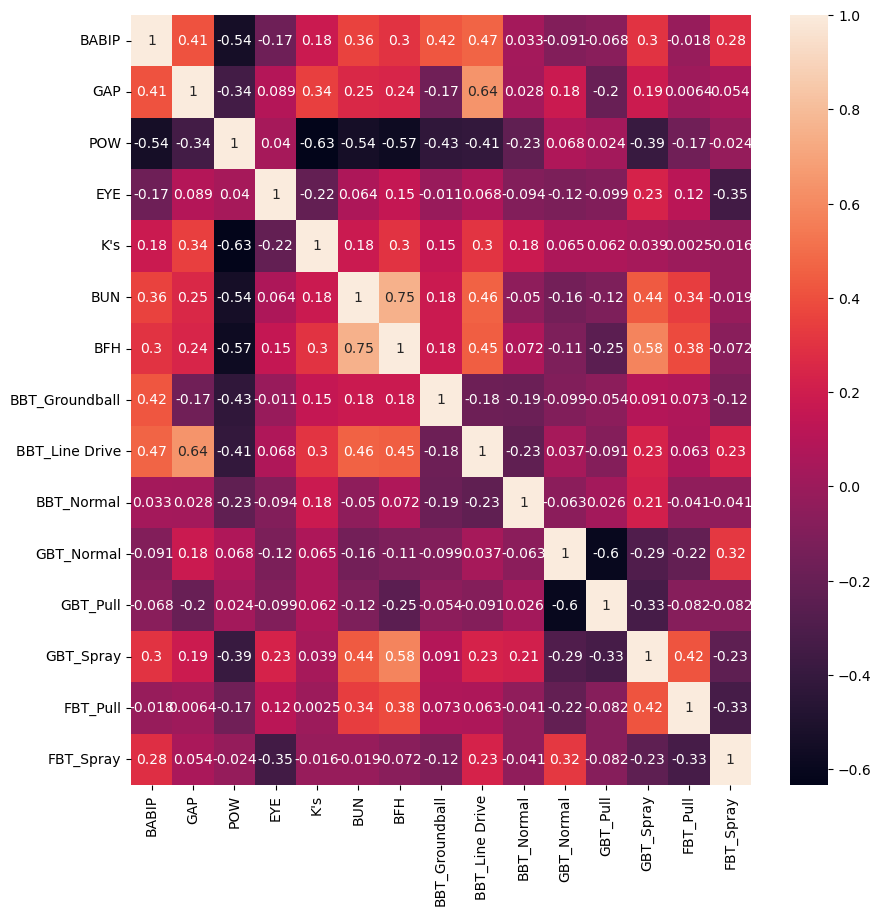

In [38]:
import seaborn as sns

plt.figure(figsize = (10, 10))
sns.heatmap(df_batters_agg_model[predictors_batters].corr(), annot = True)

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# creating dummies for gender
#data['Gender'] = data['Gender'].map({'Male':0, 'Female':1})
  
# the independent variables set
X = df_batters_agg_model[predictors_batters].astype(float).dropna()
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)
# note: VIF under 3 is fine

           feature        VIF
0            BABIP  44.095835
1              GAP  38.084070
2              POW  14.551216
3              EYE  15.921469
4              K's  13.804747
5              BUN   5.375869
6              BFH   6.469308
7   BBT_Groundball   4.592057
8   BBT_Line Drive   5.323026
9       BBT_Normal   2.805693
10      GBT_Normal   4.633669
11        GBT_Pull   4.998434
12       GBT_Spray   3.661894
13        FBT_Pull   1.912787
14       FBT_Spray   2.386751


In [40]:
# predictors and a target variable
X = np.asarray(df_batters_agg_model[predictors_batters].values, dtype=float)
y = np.asarray(df_batters_agg_model['OPS'].values, dtype=float)

# Handle missing values
X = np.nan_to_num(X, nan=0.0)  # Replace NaN values with 0
y = np.nan_to_num(y, nan=0.0)  # Replace NaN values with 0

# # Add a column of ones as the constant term to the predictor matrix
# X = np.append(arr=np.ones((X.shape[0], 1)), values=X, axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Backward OLS elimination

In [41]:
def backward_elimination(pred, dep, pn, significance_level=0.05):
    num_predictors = pred.shape[1]
    for i in range(num_predictors):
        regressor_OLS = sm.OLS(dep, pred).fit()
        max_pvalue = max(regressor_OLS.pvalues).astype(float)
        if max_pvalue > significance_level:
            for j in range(num_predictors - i):
                if regressor_OLS.pvalues[j].astype(float) == max_pvalue:
                    pred = np.delete(pred, j, 1)
                    del pn[j-1] # -1 because there's an extra constant
    regressor_OLS.summary()
    return pred, pn

In [42]:
pred_names = predictors_batters.copy()

# Addition of intercept (a column of ones)
X_trn_ols = sm.add_constant(X_train)
X_tst_ols = sm.add_constant(X_test)

# Perform backward elimination
XPN = backward_elimination(X_trn_ols, y_train, pred_names, 0.1)
X_trn_ols = XPN[0]
pred_names = XPN[1]

# Fit the final model
regressor = sm.OLS(y_train, X_trn_ols).fit()

# Print the summary of the final model
print(regressor.summary())
print("Predictor names:", pred_names, sep="\n")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     25.27
Date:                Sun, 28 May 2023   Prob (F-statistic):           1.01e-12
Time:                        10:01:17   Log-Likelihood:                 102.80
No. Observations:                  57   AIC:                            -193.6
Df Residuals:                      51   BIC:                            -181.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3346      0.042      7.998      0.0

In [43]:
# notes: Kurtosis: 3.282 -> distribution is too peaked

In [44]:
# Create a dictionary to map index labels to positions
position_dict = {label: position for position, label in enumerate(predictors_batters)}

# Retrieve positions of columns from the dictionary
column_positions = [position_dict[column] + 1 for column in pred_names]
column_positions = np.insert(column_positions, 0, 0)

# Apply results of backward elimination to test sample
X_test_be = X_tst_ols[:, column_positions]

In [45]:
from sklearn.metrics import mean_squared_log_error, r2_score

# Make predictions on the testing data
y_pred = regressor.predict(X_test_be)

RMSLE = np.sqrt( mean_squared_log_error(y_test, y_pred) )
print("The rmse score is %.5f" % RMSLE )

train_r2 = r2_score(y_true=y_test, y_pred=y_pred)
print (train_r2)

The rmse score is 0.03063
-0.13145965452774355


#### Lasso & ridge

In [46]:
from sklearn.linear_model import Lasso, Ridge

pred_names = predictors_batters.copy()

# Lasso regression
lasso = Lasso(alpha=0.01)  
            # Set the regularization parameter alpha
            # any real-valued number between zero and infinity; the larger the value, the more aggressive the penalization is.
lasso.fit(X_train, y_train)
lasso_predictions = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

# Print the coefficients
print("Lasso Coefficients:")
for feature, coef in zip(pred_names, lasso.coef_):
    if coef != 0.00000000: print(f"{feature}: {coef:.4f}") # Print out only non-zero coefs

# Print the mean squared errors
print(f"\nLasso MSE: {lasso_mse:.4f}")

## Ridge regression shrinks all regression coefficients towards zero

Lasso Coefficients:
BABIP: 0.0013
GAP: 0.0022
POW: 0.0023
EYE: 0.0005
K's: 0.0005
BUN: -0.0000
BFH: 0.0002

Lasso MSE: 0.0016


#### XGBoost

In [47]:
import xgboost as xgb

#XGBRFRegressor
xgb_model = xgb.XGBRFRegressor(objective ='reg:squarederror') # , colsample_bytree=0.2, learning_rate = 0.2, max_depth=5, alpha=5, n_estimators=40

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xgb_model.predict(X_test)

RMSLE = np.sqrt( mean_squared_log_error(y_test, y_pred) )
print("The rmse score is %.5f" % RMSLE )

train_r2 = r2_score(y_true=y_test, y_pred=y_pred)
print (train_r2)

The rmse score is 0.02816
0.0309077333921417


In [48]:
y_pred_tr = xgb_model.predict(X_train)

train_r2 = r2_score(y_true=y_train, y_pred=y_pred_tr)
print (train_r2)

0.902972569184605


In [49]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.3, learning_rate = 0.1,
                max_depth=5, alpha=10, n_estimators=10)
xg_reg.fit(X_train,y_train)
y_train_hat = xg_reg.predict(X_train)
train_r2 = r2_score(y_true=y_train, y_pred=y_train_hat)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_hat))
print (train_r2, train_rmse, y_train.mean(), y_train_hat.mean())

-7.322622262632624 0.21441631281101706 0.7477033522175883 0.54658073


In [50]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

best_xgb = GridSearchCV(
    xgb_model, param_grid={}, cv=10, verbose=0, n_jobs=-1)

scores = cross_val_score(best_xgb, X_train, y_train, scoring='r2') #cv=KFold

In [51]:
scores

array([-0.20791913, -0.75464429,  0.31761884,  0.23949621, -0.1011246 ])

In [52]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

RMSLE2 = np.sqrt( mean_squared_log_error(y_test, rf_predictions) )
print("The score is %.5f" % RMSLE2 )

The score is 0.02536


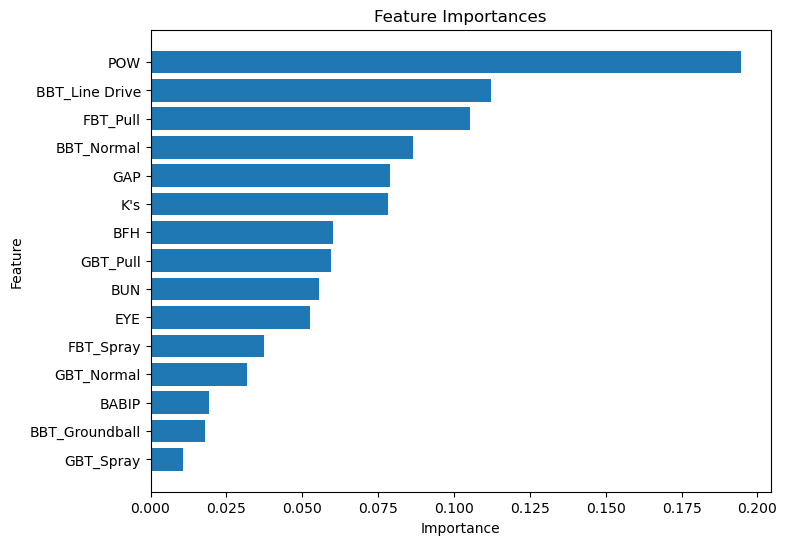

In [53]:
# Get feature importances
importance = xgb_model.feature_importances_

# Create a DataFrame to hold the feature names and importances
feature_importances = pd.DataFrame({'Feature': pred_names, 'Importance': importance})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [54]:
# NOTE: XGBoost has the ability to internally deal with categoricals -> X[col] = X[col].astype('category') + , enable_categorical=True

# model = xgb.train(
#    # Activate early stopping
#    early_stopping_rounds=50)

# to do - player classification (random forest,clustering?)